In [1]:
library(SPOTlight)
library(rhdf5)
Sys.setenv(RETICULATE_PYTHON = "/media/gambino/students_workdir/ibp/gautam/miniconda3/envs/r_kernel/bin/python")
library(reticulate)
use_condaenv(condaenv = "r_kernel", conda  = "/media/gambino/students_workdir/ibp/gautam/miniconda3/bin/conda")
library(anndata)
library(SpatialExperiment)
library(SingleCellExperiment)
library(scater)
library(scran)
library(zellkonverter)
library(Seurat)
library(dplyr)
library(Matrix)
library(ggcorrplot)
library(scatterpie)
library(colorBlindness)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCums

In [2]:
spe <- read10xVisium(
  samples = "/media/gambino/students_workdir/ibp/visium_data/Slide1/1579_deep/outs",
  sample_id = "1579_deep",
  type = "HDF5",
  data = "filtered",
  images = "lowres",
  load = FALSE
)

In [3]:
rownames(spe) <- rowData(spe)$symbol

In [4]:
adata <- read_h5ad("/media/gambino/students_workdir/ibp/Full_obj_log_counts_soupx_v2.h5ad")

In [5]:
markers_df <- read.csv("/media/gambino/students_workdir/ibp/marker_genes_cluster.csv")

In [6]:
markers_new <- as_tibble(markers_df)  %>% 
    group_by(cell_type)  %>%
    slice_min(gene_rank, n = 10)

nrow(markers_new)

[1] 90

In [7]:
idx <- split(seq(nrow(adata$obs)), (adata$obs)$category)
n_cells <- 100
cs_keep <- lapply(idx, function(i) {
    n <- length(i)
    if (n < n_cells)
        n_cells <- n
    sample(i, n_cells)
})

In [8]:
new_counts <- adata$X[unname(unlist(cs_keep)), ]
new_obs <- adata$obs[unname(unlist(cs_keep)), ]
groups_to_use <- new_obs$category

In [9]:
counts_final <- as(t(new_counts), "CsparseMatrix")

In [10]:
res <- SPOTlight(
    x = counts_final,
    y = spe,
    groups = groups_to_use,
    mgs = as.data.frame(markers_new),
    hvg = NULL,
    weight_id = "pval",
    group_id = "cell_type",
    gene_id = "gene_name")

Scaling count matrix

Seeding initial matrices

Training NMF model

Time for training: 0.22min

Deconvoluting mixture data



In [11]:
mat <- res$mat
mod <- res$NMF

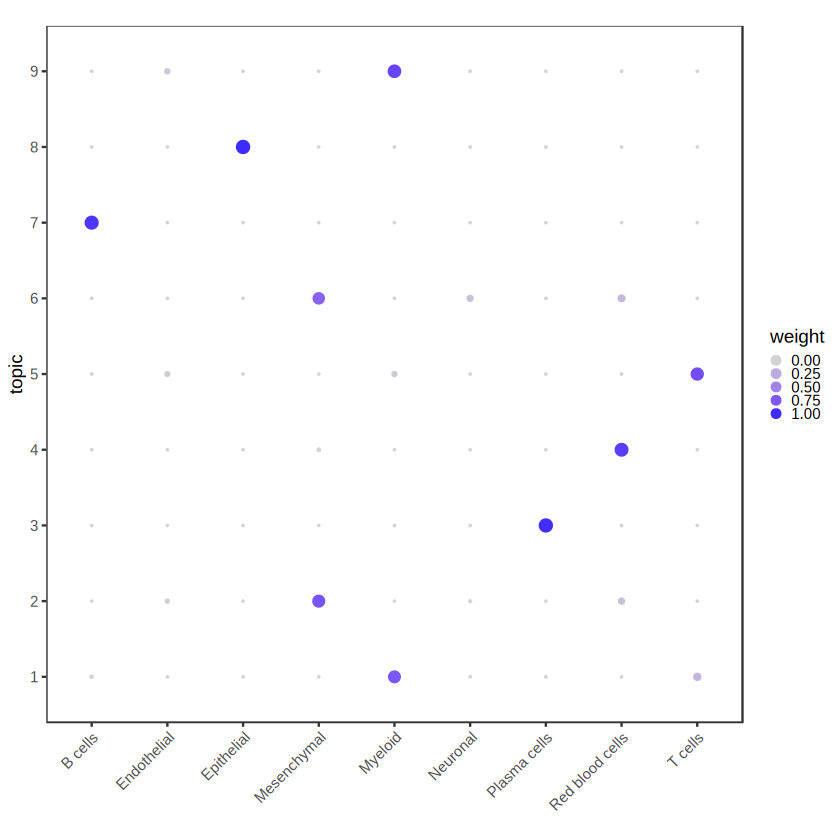

In [12]:
plotTopicProfiles(
    x = mod,
    y = groups_to_use,
    facet = FALSE,
    min_prop = 0.01,
    ncol = 1) +
    theme(aspect.ratio = 1)

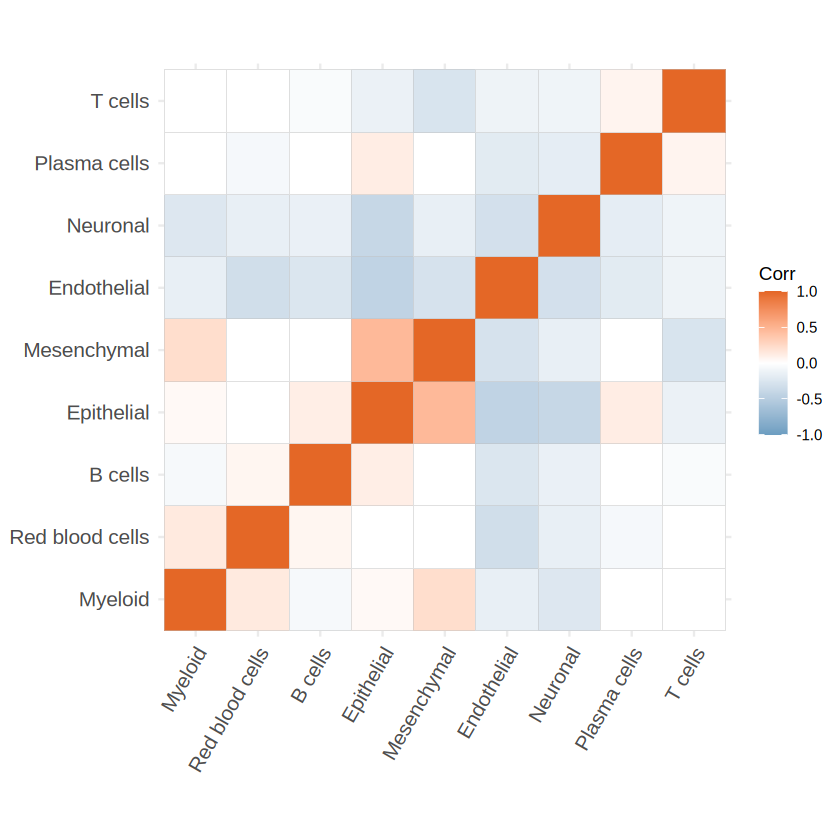

In [27]:
plotCorrelationMatrix(mat)

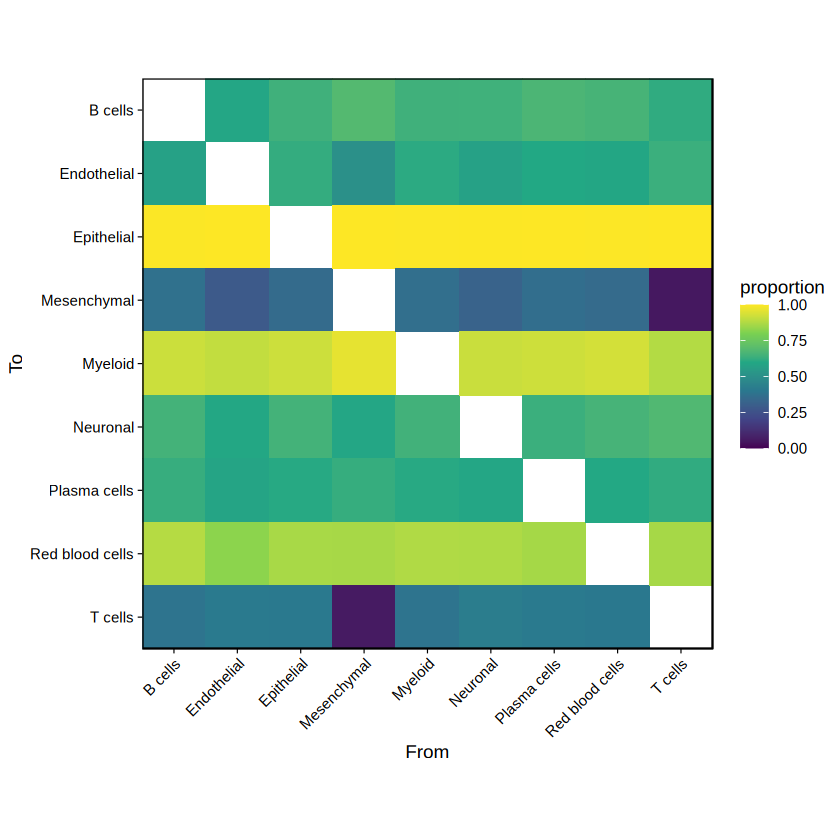

In [28]:
plotInteractions(mat, "heatmap")

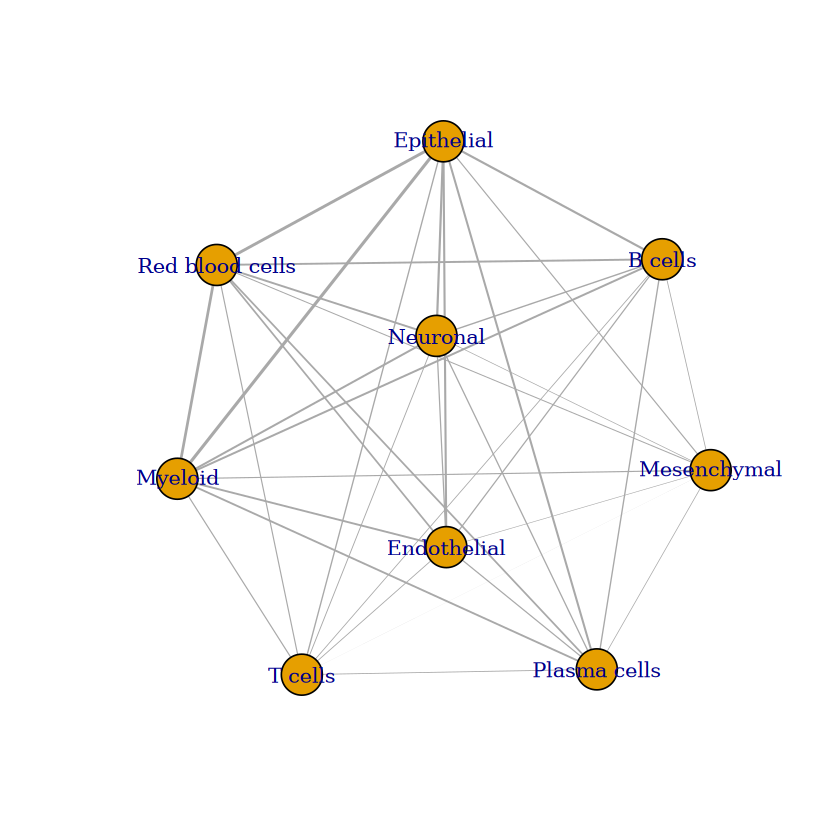

In [29]:
plotInteractions(mat, "network")

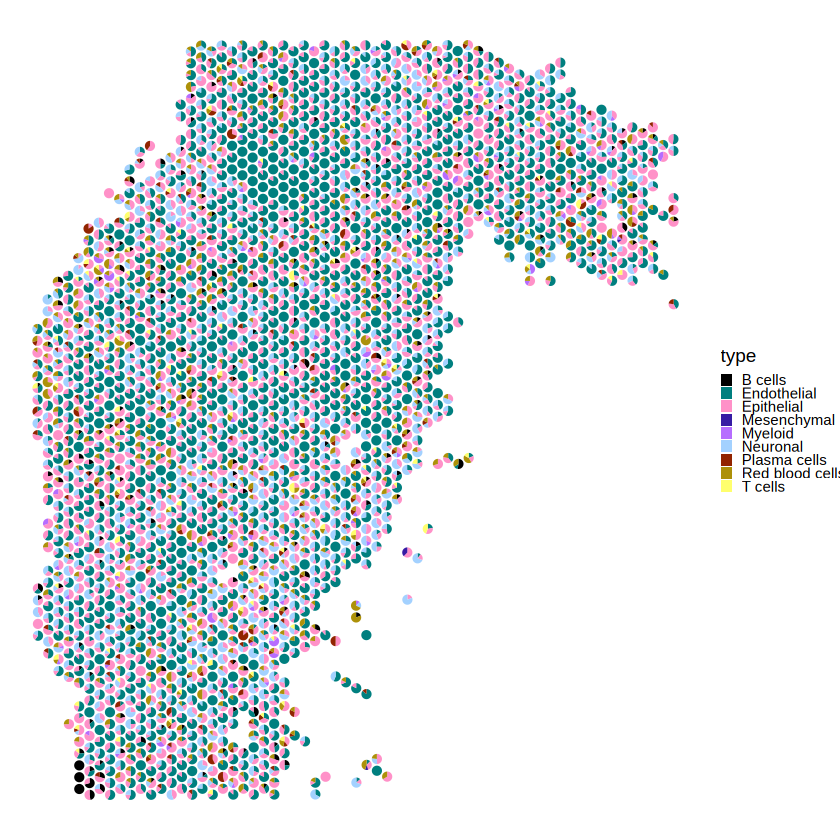

In [13]:
ct <- colnames(mat)
mat[mat < 0.1] <- 0

# Define color palette
# (here we use 'paletteMartin' from the 'colorBlindness' package)
paletteMartin <- c(
    "#000000", "#004949", "#009292", "#ff6db6", "#ffb6db", 
    "#490092", "#006ddb", "#b66dff", "#6db6ff", "#b6dbff", 
    "#920000", "#924900", "#db6d00", "#24ff24", "#ffff6d")

pal <- colorRampPalette(paletteMartin)(length(ct))
names(pal) <- ct

plotSpatialScatterpie(
    x = spe,
    y = mat,
    cell_types = colnames(mat),
    img = FALSE,
    scatterpie_alpha = 1,
    pie_scale = 0.4) +
    scale_fill_manual(
        values = pal,
        breaks = names(pal))

In [35]:
unique((adata$obs)$Integrated_05)

[1] DZ GC cell                    Cycling B cell               
  [3] gdT                           Memory B                     
  [5] Treg                          Naive B                      
  [7] Cycling plasma cell           Tfh                          
  [9] Enterocyte                    Activated CD4 T              
 [11] GC B cell                     CD8 Tmem                     
 [13] SELL+ CD8 T                   FDC                          
 [15] SELL+ CD4 T                   Th17                         
 [17] IgM plasma cell               TRGV2 gdT                    
 [19] LZ GC cell                    NK cell                      
 [21] Th1                           myofibroblast                
 [23] IgA plasma cell               TA                           
 [25] IgG plasma cell               Activated CD8 T              
 [27] NK T cell                     Stromal 1 (CCL11+)           
 [29] MMP9+ Inflammatory macrophage cDC2                         
 [31] Mature arterial EC            ILC3                         
 [33] LEC3 (ADGRG3+)                Stromal 1 (ADAMDEC1+)        
 [35] TRGV4 gdT                     STAT1+ Naive B               
 [37] T reticular                   arterial capillary           
 [39] Mast cell                     TRGV5/7 gdT                  
 [41] Stem cells                    Goblet cell                  
 [43] L cells (PYY+)                Tuft                         
 [45] FCRL4+ Memory B               Microfold cell               
 [47] EC cells (TAC1+)              Pericyte                     
 [49] cDC1                          mLTo                         
 [51] Mature venous EC              D cells (SST+)               
 [53] Stromal 2 (NPY+)              N cells (NTS+)               
 [55] LYVE1+ Macrophage             MAIT cell                    
 [57] BEST4+ epithelial             Monocytes                    
 [59] Contractile pericyte (PLN+)   Stromal 3 (C7+)              
 [61] Adult Glia                    Macrophages                  
 [63] Paneth                        Progenitor (NEUROG3+)        
 [65] Lymphoid DC                   myofibroblast (RSPO2+)       
 [67] Stromal 4 (MMP1+)             LEC1 (ACKR4+)                
 [69] BEST2+ Goblet cell            LEC4 (STAB2+)                
 [71] Stromal 2 (CH25H+)            EECs                         
 [73] Fetal arterial EC             cycling EC                   
 [75] LEC6 (ADAMTS4+)               venous capillary             
 [77] pDC                           Fetal venous EC              
 [79] CLC+ Mast cell                ILC2                         
 [81] LEC5 (CLDN11+)                LEC2 (MADCAM1+)              
 [83] Transitional Stromal 3 (C3+)  Colonocyte                   
 [85] mLN Stroma (FMO2+)            CX3CR1+ CD8 Tmem             
 [87] Mesothelium (PRG4+)           M/X cells (MLN/GHRL+)        
 [89] I cells (CCK+)                K cells (GIP+)               
 [91] LTi-like NCR- ILC3            Branch B1 (eMN)              
 [93] Pre-B                         Mesothelium                  
 [95] Immature pericyte             SMC (PLPP2+)                 
 [97] Mesoderm 2 (ZEB2+)            Stromal 3 (KCNN3+)           
 [99] SMC (PART1/CAPN3+)            Activated T                  
[101] Differentiating glia          Neuroblast                   
[103] LTi-like NCR+ ILC3            Glia 3 (BCAN+)               
[105] ICC                           MPO+ mono-neutrophil         
[107] Glia 2 (ELN+)                 Mesoderm 1 (HAND1+)          
[109] cycling stromal               Immature B                   
[111] Glia 1 (DHH+)                 RBC                          
[113] TRDV2/TRGV9 gdT               angiogenic pericyte          
[115] Pro-B                         cycling neuroblast           
[117] cycling ENCC/glia             Branch B3 (IPAN)             
[119] ILCP                          Branch A4 (IN)               
[121] Branch A1 (iMN)               Proxim

In [16]:
unique((adata$obs)$Integrated_05[(adata$obs)$category == 'Myeloid'])

[1] MMP9+ Inflammatory macrophage cDC2                         
 [3] Mast cell                     cDC1                         
 [5] LYVE1+ Macrophage             Monocytes                    
 [7] Macrophages                   Lymphoid DC                  
 [9] pDC                           CLC+ Mast cell               
[11] MPO+ mono-neutrophil          Megakaryocyte                
134 Levels: Activated CD4 T Activated CD8 T Activated T ... β cells (INS+)

In [ ]:
unique((adata$obs)$Integrated_05[(adata$obs)$category == 'Myeloid'])

In [40]:
markers_test <- read.csv('/media/gambino/students_workdir/ibp/markers_gutcellatlas.csv')

In [41]:
markers_test

X,genes,cluster,top_frac,frac_diff,max_frac_diff,top_mean_group,top_mean,mean_diff,max_mean_diff,logfoldchanges,pvals,pvals_adj,lineage
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,BEST2,BEST2+ Goblet cell,0.4813223,0.40683826,0.4643732,BEST2+ Goblet cell,0.22459412,0.196377110,0.21800509,7.393614,0.00e+00,0.00e+00,Epithelial
1,ZG16,BEST2+ Goblet cell,0.8109091,0.29777588,0.4927273,BEST2+ Goblet cell,0.44511098,0.170477780,0.39727455,6.477992,0.00e+00,0.00e+00,Epithelial
2,MUC4,BEST2+ Goblet cell,0.7074380,0.37099140,0.4635000,BEST2+ Goblet cell,0.25372040,0.157917070,0.16503592,3.174823,0.00e+00,0.00e+00,Epithelial
3,KLK1,BEST2+ Goblet cell,0.7659504,0.14962771,0.3341322,BEST2+ Goblet cell,0.36509886,0.109183640,0.24631846,3.890948,0.00e+00,0.00e+00,Epithelial
4,MUC5B,BEST2+ Goblet cell,0.5077686,0.27703202,0.3472856,BEST2+ Goblet cell,0.16142390,0.099431980,0.11541903,3.105601,0.00e+00,0.00e+00,Epithelial
5,RETNLB,BEST2+ Goblet cell,0.3176859,0.21205743,0.2566546,BEST2+ Goblet cell,0.11826469,0.088266600,0.09942878,5.734246,2.42e-184,3.99e-183,Epithelial
6,FAM3D,BEST2+ Goblet cell,0.7705785,0.08742561,0.2671757,BEST2+ Goblet cell,0.29848042,0.080372810,0.11354926,2.057527,0.00e+00,0.00e+00,Epithelial
7,IL1R2,BEST2+ Goblet cell,0.3530579,0.24921592,0.2621359,BEST2+ Goblet cell,0.10217100,0.071575160,0.07820959,3.064027,5.45e-182,8.45e-181,Epithelial
8,TPSG1,BEST2+ Goblet cell,0.4062810,0.15130913,0.2857524,BEST2+ Goblet cell,0.15702930,0.056279957,0.13006137,3.790545,1.58e-251,3.43e-250,Epithelial
